## Part B

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.ignis.verification.quantum_volume as qv

In [2]:
qubit_lists = [[0, 1, 3], [0, 1, 3, 5], [0, 1, 3, 5, 7], [0, 1, 3, 5, 7, 10]]
ntrials = 100

In [3]:
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

/home/r09222027/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/ignis/verification/quantum_volume/circuits.py:67: DeprecationWarning: Using a qubit list to map a virtual circuit to a physical layout is deprecated and will be removed in a future release. Instead use ''qiskit.transpile' with the 'initial_layout' parameter
  warnings.warn("Using a qubit list to map a virtual circuit to "
/home/r09222027/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/ignis/verification/quantum_volume/circuits.py:67: DeprecationWarning: Using a qubit list to map a virtual circuit to a physical layout is deprecated and will be removed in a future release. Instead use ''qiskit.transpile' with the 'initial_layout' parameter
  warnings.warn("Using a qubit list to map a virtual circuit to "
/home/r09222027/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/ignis/verification/quantum_volume/circuits.py:67: DeprecationWarning: Using a qubit list to map a virtual circuit to a physical layou

In [4]:
sv_sim = qiskit.Aer.get_backend('aer_simulator')
ideal_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    for qc in qv_circs_nomeas[trial]:
        qc.save_statevector()
    result = qiskit.execute(qv_circs_nomeas[trial], backend=sv_sim).result()
    ideal_results.append(result)

qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


## Part C

In [5]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [6]:
aer_sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1', 'u2', 'u3', 'cx']
shots = 1024
exp_results = []
for trial in tqdm(range(ntrials)):
    clear_output(wait=True)
    t_qcs = transpile(qv_circs[trial], basis_gates=basis_gates, optimization_level=3)
    qobj = assemble(t_qcs)
    result = aer_sim.run(qobj, noise_model=noise_model, max_parallel_experiments=0).result()
    exp_results.append(result)

100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


In [7]:
qv_fitter.add_data(exp_results)
for qubit_list in qubit_lists:
    l = len(qubit_list)
    print(f'qv_depth_{l}_trial_0:', qv_fitter._heavy_output_counts[f'qv_depth_{l}_trial_0'])

qv_depth_3_trial_0: 779
qv_depth_4_trial_0: 832
qv_depth_5_trial_0: 722
qv_depth_6_trial_0: 628


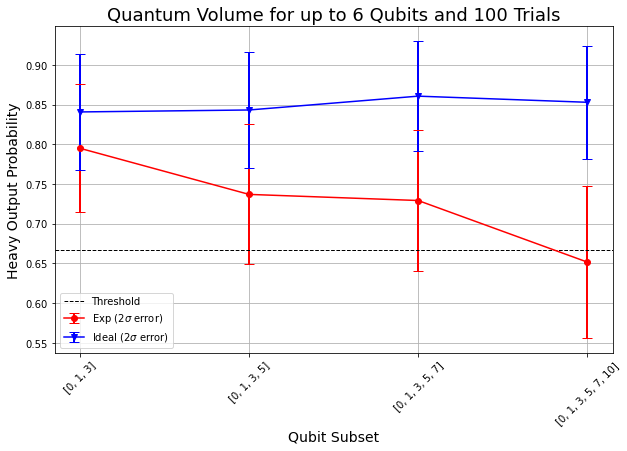

In [8]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

qv_fitter.plot_qv_data(ax=ax, show_plt=False)

ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits and {ntrials} Trials", fontsize=18)

plt.show()

In [10]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx] > 2/3:
        if qv_success_list[qidx][0]:
            QV = qv_fitter.quantum_volume()[qidx]
            print(f"Width/depth {len(qubit_list)} greater than 2/3 ({qv_list[0][qidx]}) with confidence {qv_success_list[qidx][1]} (successful). Quantum volume {QV}")
        else:
            print(f"Width/depth {len(qubit_list)} greater than 2/3 ({qv_list[0][qidx]}) with confidence {qv_success_list[qidx][1]} (unsuccessful).")
    else:
        print(f"Width/depth {len(qubit_list)} less than 2/3 (unsuccessful).")

print(f"Quantum Volume is: {QV}")

Width/depth 3 greater than 2/3 (0.79490234375) with confidence 0.999253228434221 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.736806640625) with confidence 0.9443934032229986 (unsuccessful).
Width/depth 5 greater than 2/3 (0.7291015625) with confidence 0.9199671386670839 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).
Quantum Volume is: 8
